# Transfer Learning

In [64]:
!nvidia-smi
!pwd

Tue Aug 23 13:47:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:04:00.0 Off |                    0 |
| N/A   34C    P0    33W / 250W |  12471MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   

In [80]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import json, os, sys
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

cudnn.benchmark = True
plt.ion()

path_to_be_add = '/notebook/personal/ksuchoi216/face-identification-model/'
if not path_to_be_add in sys.path:
  sys.path.insert(0, path_to_be_add)
  os.chdir(path_to_be_add)

print(f'sys.path: {sys.path}')



def load_config():
  path_for_config = './configs/config.json'
  with open(path_for_config) as f:
    cfg = json.load(f)
  
  # print(f'\nconfig file as follows:')
  # for k, v in cfg.items():
  #   print(f'{k}: {v}\n')
    
  return cfg
cfg = load_config()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sys.path: ['/notebook/personal/ksuchoi216/face-identification-model/', '/notebook', '/root/.pyenv/versions/3.9.1/lib/python39.zip', '/root/.pyenv/versions/3.9.1/lib/python3.9', '/root/.pyenv/versions/3.9.1/lib/python3.9/lib-dynload', '', '/root/.pyenv/versions/python39/lib/python3.9/site-packages']


250
 data 
0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi
batch_size: 4 

dataset length: (185) = tr (148) + val (18) + tt (19)
image dimension: (3, 250, 250)


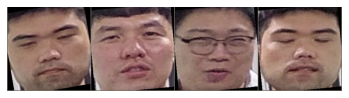

input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 2
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 2
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 2
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 3


In [66]:
from datasets import Folder_Dataset
from utils import imshow_dataloader
folder_Dataset = Folder_Dataset(cfg['data'])
dataloaders, dataset_sizes, idx_to_class = folder_Dataset.createDataLoaders()

# show a example picture 
image_size = imshow_dataloader(dataloaders["train"])

phase="train"
for i, (inputs, labels) in enumerate(dataloaders[phase]):
  if i > 3:
    break
  
  print(f'input shape: {inputs[0].shape} / label shape: {labels[0].shape} / label: {labels[0]}')
  

In [67]:
from modules import Builder

builder = Builder(cfg['model'])
print(image_size)
builder.summary(image_size)
model = builder.getModel()

device is cuda:0
Loading model was just completed.
(3, 250, 250)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 124, 124]             864
       BatchNorm2d-2         [-1, 32, 124, 124]              64
              ReLU-3         [-1, 32, 124, 124]               0
       BasicConv2d-4         [-1, 32, 124, 124]               0
            Conv2d-5         [-1, 32, 122, 122]           9,216
       BatchNorm2d-6         [-1, 32, 122, 122]              64
              ReLU-7         [-1, 32, 122, 122]               0
       BasicConv2d-8         [-1, 32, 122, 122]               0
            Conv2d-9         [-1, 64, 122, 122]          18,432
      BatchNorm2d-10         [-1, 64, 122, 122]             128
             ReLU-11         [-1, 64, 122, 122]               0
      BasicConv2d-12         [-1, 64, 122, 122]               0
        MaxPool2d-13           [-1, 64

In [68]:
# declaration for learning and testing|
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [69]:
from modules import runner
phases = ['train', 'val']
# print(runner)
model = runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=8)

Epoch 0/7
----------
after max: tensor([0.0294, 0.2436, 0.3839, 1.1191], device='cuda:0',
       grad_fn=<MaxBackward0>), tensor([3, 1, 2, 3], device='cuda:0')
train Loss: 0.6296 Acc: 0.7838
after max: tensor([4.0300, 3.2026, 4.1721, 3.4557], device='cuda:0'), tensor([3, 1, 3, 1], device='cuda:0')
val Loss: 0.0826 Acc: 1.0000

Epoch 1/7
----------
after max: tensor([4.2375, 3.2890, 4.7295, 3.5905], device='cuda:0',
       grad_fn=<MaxBackward0>), tensor([3, 2, 0, 2], device='cuda:0')
train Loss: 0.2052 Acc: 0.9257
after max: tensor([3.0296, 6.5390, 3.5935, 6.5536], device='cuda:0'), tensor([3, 0, 2, 3], device='cuda:0')
val Loss: 0.0347 Acc: 1.0000

Epoch 2/7
----------
after max: tensor([4.1328, 3.4547, 5.2901, 5.4137], device='cuda:0',
       grad_fn=<MaxBackward0>), tensor([3, 1, 0, 2], device='cuda:0')
train Loss: 0.1992 Acc: 0.9257
after max: tensor([4.8977, 4.9265, 6.3920, 3.7451], device='cuda:0'), tensor([2, 3, 3, 1], device='cuda:0')
val Loss: 0.0179 Acc: 1.0000

Epoch 3/7
---

In [72]:
phases = ['test']
runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=1)

Epoch 0/0
----------
after max: tensor([4.1986, 3.6419, 4.2929, 2.1017], device='cuda:0'), tensor([3, 3, 2, 3], device='cuda:0')
test Loss: 0.0915 Acc: 1.0000

Training complete in 0m 0s
Best val Acc: 0.000000
there is no return value becasue of test mode


In [73]:
cfg = load_config()
path_for_saving_model = cfg['path_for_saving_model']
try: 
  torch.save(model.state_dict(), path_for_saving_model)
  print(f'successfully saved model in {path_for_saving_model}')
except:
  print(f'failed saving model in {path_for_saving_model}')

successfully saved model in ./data/face-extraction-model.pt


# [TEST] face_feature_extractor with trained classifier(last layer)

In [75]:
from modules import Builder

builder = Builder(cfg['model'])
model = builder.getModel()
model.load_state_dict(torch.load(cfg['path_for_saving_model']))
model.classify = True
# model = model.to('cpu')
model.eval()

device is cuda:0
Loading model was just completed.


InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [88]:
phases = ['test']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for phase in phases:
  for i, (inputs, labels) in enumerate(dataloaders[phase]):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    print('outputs before softmax:', outputs)
    outputs = F.softmax(outputs)
    print('outputs after softmax:', outputs)
    values, preds = torch.max(outputs, 1)
    print(values)
    
    
    print('\n')
    if i > 2:
      break
    

outputs before softmax: tensor([[-3.0912,  0.8088, -1.1772,  4.4912],
        [ 4.7713, -1.4637, -3.1102, -0.4490],
        [-0.3488,  0.0236, -2.2083,  3.4013],
        [-0.3352,  3.0707, -1.2262, -1.1418]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
outputs after softmax: tensor([[4.9489e-04, 2.4449e-02, 3.3557e-03, 9.7170e-01],
        [9.9232e-01, 1.9445e-03, 3.7475e-04, 5.3638e-03],
        [2.2157e-02, 3.2155e-02, 3.4509e-03, 9.4224e-01],
        [3.1251e-02, 9.4198e-01, 1.2821e-02, 1.3950e-02]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([0.9717, 0.9923, 0.9422, 0.9420], device='cuda:0',
       grad_fn=<MaxBackward0>)


outputs before softmax: tensor([[-0.9604,  3.7280, -0.3457, -2.0672],
        [-1.5395,  0.4777, -2.0260,  3.7428],
        [-1.1082,  0.0747, -1.3357,  1.7025],
        [-0.0437,  0.6600, -1.5427,  2.2790]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
outputs after softmax: tensor([[0.0089, 0.9716, 0.0165, 0.0030],
        [0.0049, 0